In [5]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from pymbar import timeseries as ts

# Analysis saltswap results
## Applied chemical potential: $\Delta\mu = 750$

Defining a functions to read the simulation data, and generating pretty colours for plotting.

In [6]:
def read_data(filename):
    """
    Read the number of salt molecules added, acceptance rates, and simulation run times for iterations of saltswap
    
    Parameters
    ----------
    filename: str
      the name of the file that contains the simulation data
      
    Returns
    -------
    data: numpy.ndarray
      array containing number of waters, number of salt pairs, acceptance probability, and run-time per iteration
    """
    filelines = open(filename).readlines()
    Nwats = []
    Nsalt = []
    Accprob = []
    time = []
    #i=3
    #step = int(filelines[i][0:5].strip())
    #while i-3 == step:
    #while i > 0:
    for i in range(3,len(filelines)-3):
        # It appears some of the files have a varying length. This exception will pick those up.
        try:
            dummy = int(filelines[i][6:10].strip())
        except ValueError:
            break
        Nwats.append(int(filelines[i][6:10].strip()))
        Nsalt.append(int(filelines[i][13:18].strip()))
        #print 'nsalt', int(filelines[i][13:18].strip())
        Accprob.append(float(filelines[i][19:24].strip()))
        #print 'acc', filelines[i][19:24].strip()
        time.append(int(filelines[i][35:40].strip()))
        #print 'time', filelines[i][35:40].strip()
        #i += 1
    return np.vstack((np.array(Nwats),np.array(Nsalt),np.array(Accprob),np.array(time)))

def read_work(filename):
    """
    Function to read the work to add or remove salt in a saltswap simulation.
    
    Parameter
    ---------
    filename: str
      the name of the file containing the work for each attempt
      
    Returns
    -------
    work: numpy.ndarray
      array of work values
    """
    filelines = open(filename).readlines()
    work = []
    for i in range(2,len(filelines)):
        work += [float(wrk) for wrk in filelines[i].split()]
    return np.array(work)    


# Nice colours, taken on 26th Nov 2015 from:
#http://tableaufriction.blogspot.co.uk/2012/11/finally-you-can-use-tableau-data-colors.html

# These are the "Tableau" colors as RGB. I've chosen my faves. 
# In order: blue, green, purple, orange. Hopefully a good compromise for colour-blind people.
tableau4 = [(31, 119, 180),(44, 160, 44),(148,103,189),(255, 127, 14)]
tableau4_light = [(174,199,232),(152,223,138),(197,176,213),(255,187,120)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts. 
for i in range(len(tableau4)):    
    r, g, b = tableau4[i]    
    tableau4[i] = (r / 255., g / 255., b / 255.)
    r, g, b = tableau4_light[i]    
    tableau4_light[i] = (r / 255., g / 255., b / 255.)

## Work distributions
### # perturbations = 32768, # propagations = 1 
Looking at # perturbations = 4096, # propagations = 4 as it's the most computationally expensive protocol.

In [7]:
kT = 2.479
print 'Chemical potential in units of kT =', 750/kT

Chemical potential in units of kT = 302.541347317


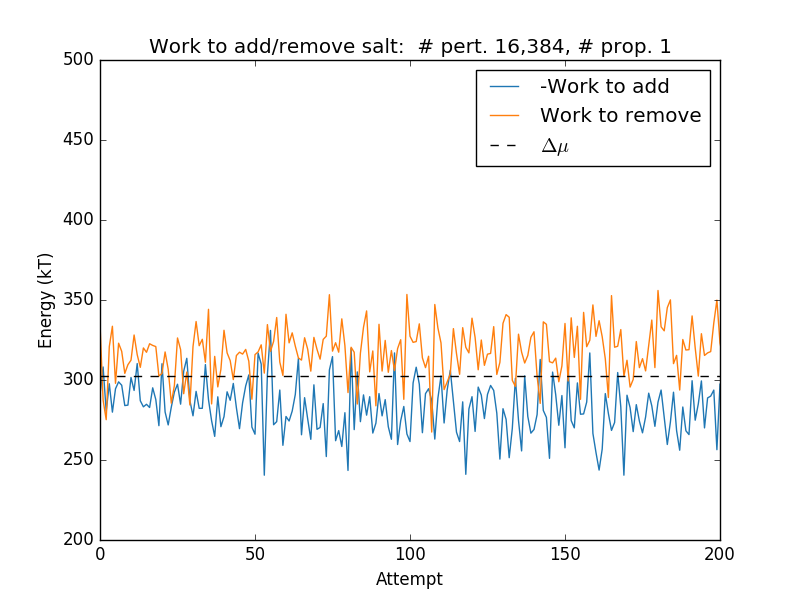

In [19]:
work_add = read_work('Titration750_barostat/prt16384_prp1/work_add_data.txt')
work_rm = read_work('Titration750_barostat/prt16384_prp1/work_rm_data.txt')


plt.clf()
plt.plot(-work_add, color=tableau4[0])
plt.plot(work_rm, color=tableau4[3])
plt.axhline(750/kT, ls='--', color='k')

plt.title('Work to add/remove salt:  # pert. 16,384, # prop. 1')
plt.legend(('-Work to add','Work to remove','$\Delta \mu$'),loc=0)
plt.xlabel('Attempt')
plt.ylabel('Energy (kT)')
plt.xlim((0,200))

plt.savefig('temp.png',format='png')
Image('temp.png')

This plot shows the work to remove (orange line) and the negative of the work to add salt (blue line) for the first 200 steps of a simulation with an arbitrary chemical potential (dotted line). The NCMC protocol was 32,768 steps, with a 1fs timestep (i.e. ~33ps)

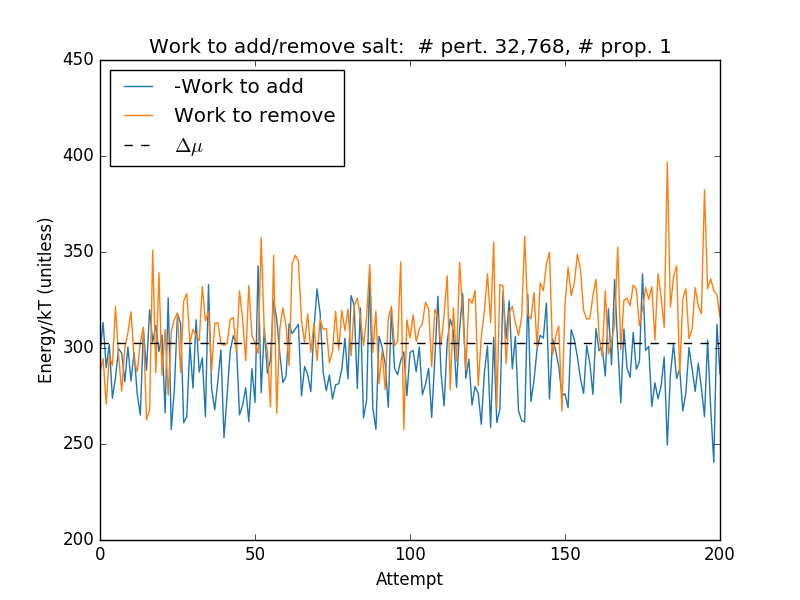

In [20]:
work_add = read_work('Titration750_barostat/prt32768_prp1/work_add_data.txt')
work_rm = read_work('Titration750_barostat/prt32768_prp1/work_rm_data.txt')


plt.clf()
plt.plot(-work_add, color=tableau4[0])
plt.plot(work_rm, color=tableau4[3])
plt.axhline(750/kT, ls='--', color='k')

plt.title('Work to add/remove salt:  # pert. 32,768, # prop. 1')
plt.legend(('-Work to add','Work to remove','$\Delta \mu$'),loc=0)
plt.xlabel('Attempt')
plt.ylabel('Energy/kT (unitless)')
plt.xlim((0,200))

plt.savefig('temp.png',format='png')
Image('temp.png')

The work to remove salt increases are more salt is added to the system. This is the opposite of what we want, as this incourages more salt to enter the system.

### How Work decreases with longer protocol
Given the increase in salt pairs over time, I'll only look at the work distributions for the first 500 insertion/deletion attempts.

In [14]:
params = [(16384,1),(32768,1),(65536,1)]

N = 322
work_add = np.zeros((3,N))
work_rm = np.zeros((3,N))

for i in range(len(params)):
    filename = 'Titration750_barostat/prt{0}_prp{1}/work_add_data.txt'.format(params[i][0],params[i][1])
    work_add[i,:] = read_work(filename)[0:N]
    filename = 'Titration750_barostat/prt{0}_prp{1}/work_rm_data.txt'.format(params[i][0],params[i][1])
    work_rm[i,:] = read_work(filename)[0:N]

### Histogram of work to add salt

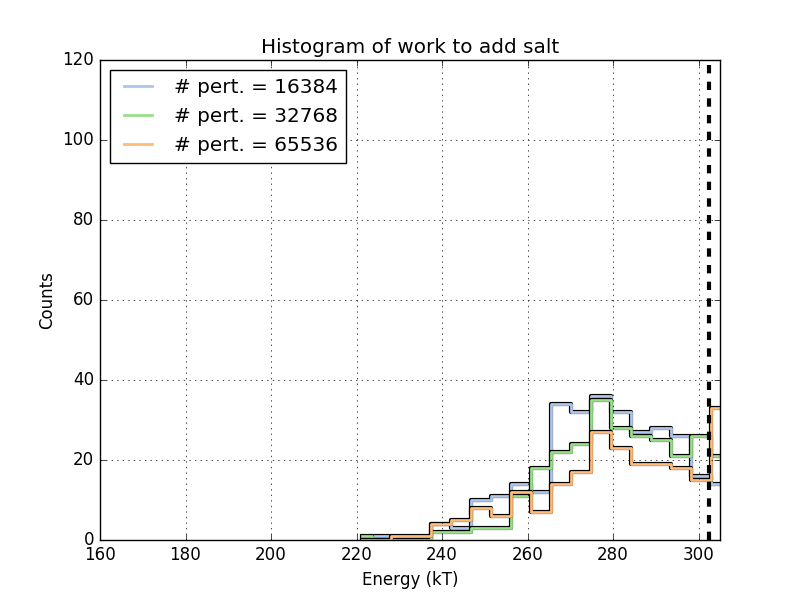

In [15]:
# Automatically calculate the histogram of all the data, and save the edges and midpoints
counts, edges = np.histogram(-work_add,30)
midpoints =  edges[0:-1] + np.diff(edges)/2.0

colours = (tableau4_light[0], tableau4_light[1], tableau4_light[3])
plt.clf()
lines = []
for i in range(3):
    cnts, junk = np.histogram(a = -work_add[i,:], bins = edges)
    plt.step(midpoints, cnts, where='mid',color='k', lw = 3)
    lines.append(plt.step(midpoints, cnts, where='mid', color=colours[i], lw = 2, label = '# pert. = {0}'.format(params[i][0])))
plt.axvline(750/kT, ls='--', color='k',lw=3)    

plt.ylim((0,120))
plt.xlim((160,305))
plt.legend(loc=0)
plt.title('Histogram of work to add salt')
plt.ylabel('Counts')
plt.xlabel('Energy (kT)')
plt.grid()
plt.savefig(filename="Hist_Work_Add.png")
Image(filename="Hist_Work_Add.png")

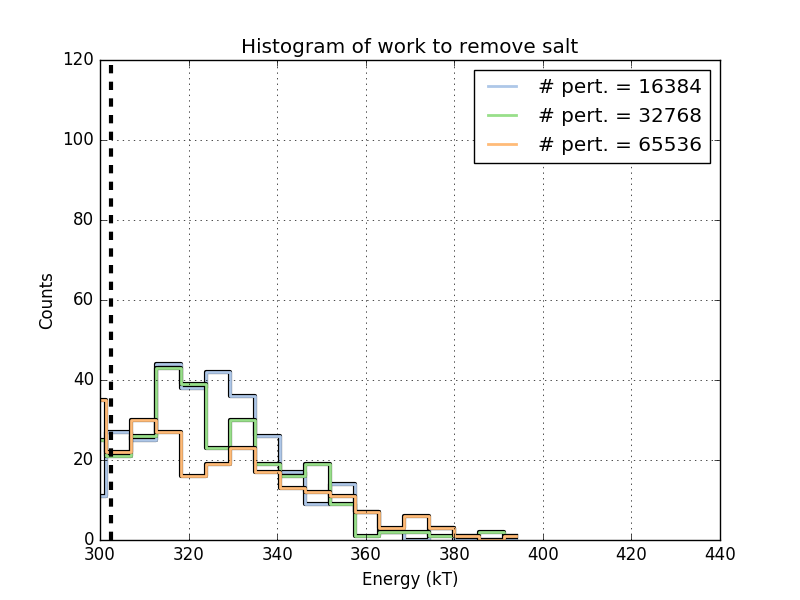

In [16]:
# Automatically calculate the histogram of all the data, and save the edges and midpoints
counts, edges = np.histogram(work_rm,30)
midpoints =  edges[0:-1] + np.diff(edges)/2.0

colours = (tableau4_light[0], tableau4_light[1], tableau4_light[3])
plt.clf()
lines = []
for i in range(3):
    cnts, junk = np.histogram(a = work_rm[i,:], bins = edges)
    plt.step(midpoints, cnts, where='mid',color='k', lw = 3)
    lines.append(plt.step(midpoints, cnts, where='mid', color=colours[i], lw = 2, label = '# pert. = {0}'.format(params[i][0])))
plt.axvline(750/kT, ls='--', color='k',lw=3)    

plt.ylim((0,120))
plt.xlim(300,440)
plt.legend(loc=0)
plt.title('Histogram of work to remove salt')
plt.ylabel('Counts')
plt.xlabel('Energy (kT)')
plt.grid()
plt.savefig(filename="Hist_Work_Rm.png")
Image(filename="Hist_Work_Rm.png")

The location and spread of the work decreases as the length of the protocol decreases.